In [311]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [312]:
%cd /content/drive/MyDrive/Colab Notebooks/data

/content/drive/MyDrive/Colab Notebooks/data


In [313]:
%ls

barcode_search_results.json  solar_production.json          weather.csv
consumption.json             synthetic_search_results.json


In [314]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

In [315]:
barcode_df = pd.read_json("barcode_search_results.json")
synthetic_df = pd.read_json("synthetic_search_results.json")
#barcode_df.head()
#synthetic_df.head()

**Results**

In [316]:
#select .json file you want to open
with open('barcode_search_results.json') as data_file:    
    data = json.load(data_file)   

In [317]:
#data_norm_hits = pd.json_normalize(data,record_path=['records','spectrumCollections','spectra','hits'])

In [318]:
data_norm = pd.json_normalize(data,record_path=['records'])

Create a binary column of whether the hit is true-positive or false-positive

In [319]:
x = []

for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
  for k in range(num_of_hits):
    #extract hits corresponding to each record
    data_norm_hits = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']
    if(data_norm['InChIKey'][i] == int(data_norm_hits)):
      value = [1]
      x = x + value
    else:
      value = [0]
      x = x + value

len(x)
binary_column = pd.DataFrame(x)
binary_column = binary_column.rename(columns={0:'binary_value'})
binary_column

,binary_value
0,1
1,0
2,1
3,0
4,1
...,...
262,0
263,1
264,0
265,1


Number of correct hits and incorrect hits - altogether (from all 267 hits, regardless of compound)

In [320]:
corr = len(binary_column[binary_column['binary_value']==1])
incorr = len(binary_column[binary_column['binary_value']==0])
print("Number of correct hits: %(corr)d" % {"corr": corr})
print("Number of incorrect hits: %(incorr)d" % {"incorr": incorr})

Number of correct hits: 92
Number of incorrect hits: 175


**For each compound** compute the number of correct hits and incorrect hits 

In [321]:
correct_hits = list(range(len(data_norm)))
incorrect_hits = list(range(len(data_norm)))

for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
  sum_correct = 0
  sum_incorrect = 0
  for k in range(num_of_hits):
    data_norm_hits = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']
    #compute sum of correct and incorrect hits for each record/compound
    if(data_norm['InChIKey'][i] == int(data_norm_hits)):
      sum_correct = sum_correct + 1
    else:
      sum_incorrect = sum_incorrect + 1

  correct_hits[i] = sum_correct
  incorrect_hits[i] = sum_incorrect

#len(correct_hits),len(incorrect_hits)

In [322]:
correct_hits_df = pd.DataFrame(correct_hits)
correct_hits_df = correct_hits_df.rename(columns={0:'num_of_correct_hits'})

In [323]:
incorrect_hits_df = pd.DataFrame(incorrect_hits)
incorrect_hits_df = incorrect_hits_df.rename(columns={0:'num_of_incorrect_hits'})

In [324]:
result = pd.concat([correct_hits_df, incorrect_hits_df], axis=1)
result

,num_of_correct_hits,num_of_incorrect_hits
0,1,1
1,1,0
2,1,1
3,0,1
4,1,1
...,...,...
89,1,2
90,1,0
91,1,1
92,1,2


At least one correct hit vs. all incorrect

In [325]:
print("At least one correct hit:" + str(result[result.num_of_correct_hits > 0].count()[1]))
print("Only incorrect hits:" + str(result[result.num_of_correct_hits == 0].count()[1]))

At least one correct hit:88
Only incorrect hits:6


In [326]:
a = result[result.num_of_correct_hits > 0].count()[1]
b = result[result.num_of_correct_hits == 0].count()[1]

perc_correct = a/(a+b)*100
perc_incorrect = b/(a+b)*100

perc_correct, perc_incorrect

(93.61702127659575, 6.382978723404255)

Relate the ranking of candidates based on their score to the number of potential hits (all hits).

In [ ]:
num_of_hits = list(range(len(data_norm)))
for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits[i] = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])

len(num_of_hits)
num_of_hits

Scores/relative ranks computed for all hits, considering all three ranks

In [328]:
norm_data_hits = pd.json_normalize(data,record_path=['records','spectrumCollections','spectra','hits'])
#norm_data_hits['nistMatch_rank']
#len(norm_data_hits)

In [ ]:
rrank_cosine = []
rrank_denver = []
rrank_nist = []

for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
  for k in range(num_of_hits):
    cosine = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['cosineMatch_rank']
    denver = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['denverMatch_rank']
    nist = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['nistMatch_rank']
    #compute scores/relative rank
    if(num_of_hits == 1):
      score_cosine = 0
      score_denver = 0
      score_nist = 0
    else:
      score_cosine = (cosine - 1) / (num_of_hits - 1)
      score_denver = (denver - 1) / (num_of_hits - 1)
      score_nist = (nist- 1) / (num_of_hits - 1)

    rrank_cosine = rrank_cosine + [score_cosine]
    rrank_denver = rrank_denver + [score_denver]
    rrank_nist = rrank_nist + [score_nist]

#len(rrank_cosine)
rrank_cosine

In [330]:
rrank_cosine_df = pd.DataFrame(rrank_cosine)
rrank_cosine_df = rrank_cosine_df.rename(columns={0:'cosine_relative_rank'})

rrank_denver_df = pd.DataFrame(rrank_denver)
rrank_denver_df = rrank_denver_df.rename(columns={0:'denver_relative_rank'})

rrank_nist_df = pd.DataFrame(rrank_nist)
rrank_nist_df = rrank_nist_df.rename(columns={0:'nist_relative_rank'})

rranks = pd.concat([rrank_cosine_df, rrank_denver_df, rrank_nist_df], axis=1)
rranks.index.names = ['hits']
rranks

,cosine_relative_rank,denver_relative_rank,nist_relative_rank
hits,,,
0,0.0,0.0,0.0
1,1.0,1.0,1.0
2,0.0,0.0,0.0
3,1.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
262,0.0,0.0,0.0
263,0.5,0.5,0.5
264,1.0,1.0,1.0


Plot true-positive rate vs. rank threshold

In [331]:
treshold_array = norm_data_hits['cosineMatch_rank'].unique()
#norm_data_hits['denverMatch_rank'].unique()
#norm_data_hits['nistMatch_rank'].unique()

treshold = list(treshold_array)
treshold.sort()
treshold

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [332]:
TPRc = list(range(len(treshold)))
TPRd = list(range(len(treshold)))
TPRn = list(range(len(treshold)))

for j in range(len(treshold)):
  TPc = 0 #number of true-positive hits for cosine rank
  FPc = 0 #number of false-positive hits for cosine rank
  TPd = 0 #number of true-positive hits for denver rank
  FPd = 0 #number of false-positive hits for denver rank
  TPn = 0 #number of true-positive hits for nist rank
  FPn = 0 #number of false-positive hits for nist rank
  for i in range(len(data_norm)):
    #compute number of hits for each record
    num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
    for k in range(num_of_hits):
      cosine_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['cosineMatch_rank']
      denver_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['denverMatch_rank']
      nist_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['nistMatch_rank']
      if(cosine_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPc = TPc + 1
        else:
          FPc = FPc + 1
      if(denver_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPd = TPd + 1
        else:
          FPd = FPd + 1
      if(nist_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPn = TPn + 1
        else:
          FPn = FPn + 1

  TPRc[j] = TPc/(TPc + FPc)
  TPRd[j] = TPd/(TPd + FPd)
  TPRn[j] = TPn/(TPn + FPn)

TPRc
#TPRd
#TPRn


[0.7340425531914894,
 0.6,
 0.5089820359281437,
 0.46994535519125685,
 0.4494949494949495,
 0.4238095238095238,
 0.4009009009009009,
 0.3888888888888889,
 0.37551020408163266,
 0.359375,
 0.3445692883895131]

In [333]:
np.array((TPRc,TPRd,TPRn)).T

array([[0.73404255, 0.76595745, 0.74468085],
       [0.6       , 0.60714286, 0.6       ],
       [0.50898204, 0.51497006, 0.52095808],
       [0.46994536, 0.4863388 , 0.48087432],
       [0.44949495, 0.45454545, 0.44444444],
       [0.42380952, 0.42857143, 0.42380952],
       [0.4009009 , 0.40540541, 0.4009009 ],
       [0.38888889, 0.39316239, 0.39316239],
       [0.3755102 , 0.3755102 , 0.3755102 ],
       [0.359375  , 0.359375  , 0.359375  ],
       [0.34456929, 0.34456929, 0.34456929]])

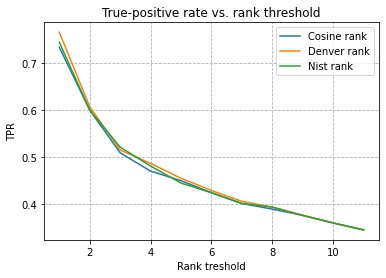

In [334]:
plt.plot(treshold, TPRc, label = "Cosine rank")
plt.plot(treshold, TPRd, label = "Denver rank")
plt.plot(treshold, TPRn, label = "Nist rank")
plt.title('True-positive rate vs. rank threshold')
plt.legend()
plt.xlabel('Rank treshold')
plt.ylabel('TPR')
plt.grid(linestyle = '--')
plt.show()

In [335]:
TPRc = list(range(len(treshold)))
TPRd = list(range(len(treshold)))
TPRn = list(range(len(treshold)))
TPc = list(range(len(data_norm))) #number of true-positive hits for cosine rank
FPc = list(range(len(data_norm))) #number of false-positive hits for cosine rank
TPd = list(range(len(data_norm))) #number of true-positive hits for denver rank
FPd = list(range(len(data_norm))) #number of false-positive hits for denver rank
TPn = list(range(len(data_norm))) #number of true-positive hits for nist rank
FPn = list(range(len(data_norm))) #number of false-positive hits for nist rank

for j in range(len(treshold)):
  tpcc = []
  for i in range(len(data_norm)):
    tpc = []
    tpd = []
    tpn = []
    #compute number of hits for each record
    num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
    for k in range(num_of_hits):
      cosine_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['cosineMatch_rank']
      denver_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['denverMatch_rank']
      nist_rank = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['nistMatch_rank']
      if(cosine_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          is_tpc = True
        else:
          is_tpc = False
        tpc.append(is_tpc)
        tpcc.append(is_tpc)
      if(denver_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          is_tpd = True
        else:
          is_tpd = False
        tpd.append(is_tpd)
      if(nist_rank <= treshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          is_tpn = True
        else:
          is_tpn = False
        tpn.append(is_tpn)

    if(any(tpc)):
      TPc[i] = 1
      FPc[i] = 0
    else:
      FPc[i] = 1
      TPc[i] = 0
    if(any(tpd)):
      TPd[i] = 1
      FPd[i] = 0
    else:
      FPd[i] = 1
      TPd[i] = 0
    if(any(tpn)):
      TPn[i] = 1
      FPn[i] = 0
    else:
      FPn[i] = 1
      TPn[i] = 0
    
  TPRc[j] = sum(TPc)/(sum(FPc) + sum(TPc))
  TPRd[j] = sum(TPd)/(sum(FPd) + sum(TPd))
  TPRn[j] = sum(TPn)/(sum(FPn) + sum(TPn))

np.array((TPRc,TPRd,TPRn)).T

array([[0.73404255, 0.76595745, 0.74468085],
       [0.85106383, 0.86170213, 0.85106383],
       [0.86170213, 0.87234043, 0.88297872],
       [0.87234043, 0.90425532, 0.89361702],
       [0.90425532, 0.91489362, 0.89361702],
       [0.90425532, 0.91489362, 0.90425532],
       [0.90425532, 0.91489362, 0.90425532],
       [0.92553191, 0.93617021, 0.93617021],
       [0.93617021, 0.93617021, 0.93617021],
       [0.93617021, 0.93617021, 0.93617021],
       [0.93617021, 0.93617021, 0.93617021]])

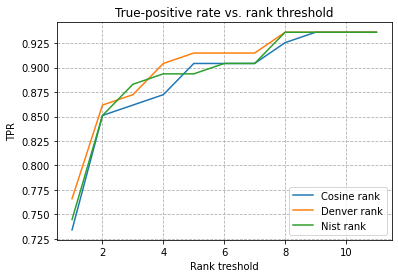

In [336]:
plt.plot(treshold, TPRc, label = "Cosine rank")
plt.plot(treshold, TPRd, label = "Denver rank")
plt.plot(treshold, TPRn, label = "Nist rank")
plt.title('True-positive rate vs. rank threshold')
plt.legend()
plt.xlabel('Rank treshold')
plt.ylabel('TPR')
plt.grid(linestyle = '--')
plt.show()

Plot true-positive rate vs. relative rank threshold

In [337]:
rtreshold = np.linspace(0,1,11)
rtreshold

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
num_of_hits = list(range(len(data_norm)))
for i in range(len(data_norm)):
  #compute number of hits for each record
  num_of_hits[i] = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])

len(num_of_hits)
num_of_hits

In [339]:
it_cosine = iter(rrank_cosine)
sliced_cosine = [list(islice(it_cosine, 0, i)) for i in num_of_hits]
#sliced_cosine

In [340]:
it_denver = iter(rrank_denver)
sliced_denver = [list(islice(it_denver, 0, i)) for i in num_of_hits]
#sliced_denver

In [341]:
it_nist = iter(rrank_nist)
sliced_nist = [list(islice(it_nist, 0, i)) for i in num_of_hits]

In [342]:
TPRcr = list(range(len(rtreshold)))
TPRdr = list(range(len(rtreshold)))
TPRnr = list(range(len(rtreshold)))
TPcr = list(range(len(data_norm)))
FPcr = list(range(len(data_norm)))
TPdr = list(range(len(data_norm)))
FPdr = list(range(len(data_norm)))
TPnr = list(range(len(data_norm)))
FPnr = list(range(len(data_norm)))

for j in range(len(rtreshold)):
  for i in range(len(data_norm)):
    tpc = []
    tpd = []
    tpn = []
    #compute number of hits for each record
    n_of_hits = n_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
    for k in range(n_of_hits):
      cosine_rrank = sliced_cosine[i][k]
      denver_rrank = sliced_denver[i][k]
      nist_rrank = sliced_nist[i][k]
      if(cosine_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          is_tpc = True
        else:
          is_tpc = False
        tpc.append(is_tpc)
      if(denver_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          is_tpd = True
        else:
          is_tpd = False
        tpd.append(is_tpd)
      if(nist_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          is_tpn = True
        else:
          is_tpn = False
        tpn.append(is_tpn)

    if(any(tpc)):
      TPcr[i] = 1
      FPcr[i] = 0
    else:
      FPcr[i] = 1
      TPcr[i] = 0
    if(any(tpd)):
      TPdr[i] = 1
      FPdr[i] = 0
    else:
      FPdr[i] = 1
      TPdr[i] = 0
    if(any(tpn)):
      TPnr[i] = 1
      FPnr[i] = 0
    else:
      FPnr[i] = 1
      TPnr[i] = 0

  TPRcr[j] = sum(TPcr)/(sum(TPcr) + sum(FPcr))
  TPRdr[j] = sum(TPdr)/(sum(TPdr) + sum(FPdr))
  TPRnr[j] = sum(TPnr)/(sum(TPnr) + sum(FPnr))

#TPRcr
#TPRdr
#TPRnr


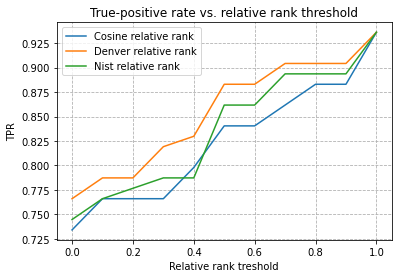

In [343]:
plt.plot(rtreshold, TPRcr, label = "Cosine relative rank")
plt.plot(rtreshold, TPRdr, label = "Denver relative rank")
plt.plot(rtreshold, TPRnr, label = "Nist relative rank")
plt.title('True-positive rate vs. relative rank threshold')
plt.legend()
plt.xlabel('Relative rank treshold')
plt.ylabel('TPR')
plt.grid(linestyle = '--')
plt.show()

In [344]:
TPRcr = list(range(len(rtreshold)))
TPRdr = list(range(len(rtreshold)))
TPRnr = list(range(len(rtreshold)))

for j in range(len(rtreshold)):
  TPcr = 0 #number of true-positive hits for cosine relative rank
  FPcr = 0 #number of false-positive hits for cosine relative rank
  TPdr = 0 #number of true-positive hits for denver relative rank
  FPdr = 0 #number of false-positive hits for denver relative rank
  TPnr = 0 #number of true-positive hits for nist relative rank
  FPnr = 0 #number of false-positive hits for nist relative rank
  for i in range(len(data_norm)):
    #compute number of hits for each record
    n_of_hits = n_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
    for k in range(n_of_hits):
      cosine_rrank = sliced_cosine[i][k]
      denver_rrank = sliced_denver[i][k]
      nist_rrank = sliced_nist[i][k]
      if(cosine_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPcr = TPcr + 1
        else:
          FPcr = FPcr + 1
      if(denver_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPdr = TPdr + 1
        else:
          FPdr = FPdr + 1
      if(nist_rrank <= rtreshold[j]):
        if(int(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['InChIKey_hits']) == data['records'][i]['InChIKey']):
          TPnr = TPnr + 1
        else:
          FPnr = FPnr + 1

    TPRcr[j] = TPcr/(TPcr + FPcr)
    TPRdr[j] = TPdr/(TPdr + FPdr)
    TPRnr[j] = TPnr/(TPnr + FPnr)

#TPRcr
#TPRdr
#TPRnr


In [345]:
np.array((TPRcr,TPRdr,TPRnr)).T

array([[0.73404255, 0.76595745, 0.74468085],
       [0.68571429, 0.7047619 , 0.68571429],
       [0.62393162, 0.64102564, 0.63247863],
       [0.5530303 , 0.59090909, 0.56818182],
       [0.53472222, 0.55555556, 0.52777778],
       [0.47647059, 0.5       , 0.48823529],
       [0.44505495, 0.46703297, 0.45604396],
       [0.42783505, 0.44845361, 0.44329897],
       [0.40669856, 0.41626794, 0.41148325],
       [0.38461538, 0.39366516, 0.38914027],
       [0.34456929, 0.34456929, 0.34456929]])

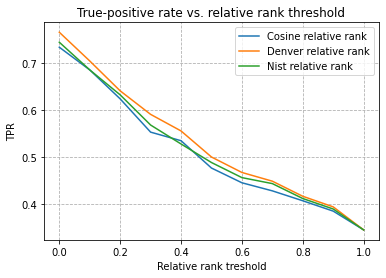

In [346]:
plt.plot(rtreshold, TPRcr, label = "Cosine relative rank")
plt.plot(rtreshold, TPRdr, label = "Denver relative rank")
plt.plot(rtreshold, TPRnr, label = "Nist relative rank")
plt.title('True-positive rate vs. relative rank threshold')
plt.legend()
plt.xlabel('Relative rank treshold')
plt.ylabel('TPR')
plt.grid(linestyle = '--')
plt.show()